In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# waves light path
waves_n_path = '/Users/sp624AA/Downloads/waves_light/WAVES-S_d1m3p1f1_light.parquet'
waves_n_check_path = '/Users/sp624AA/Downloads/waves_data/waves_s_d13p1f1_mask_check.dat'

In [5]:
# load in data
waves_n = pd.read_parquet(waves_n_path)
#
#waves_n_check = pd.read_csv(waves_n_check_path, delim_whitespace=True, header=None)

In [6]:
def read_polygon_file(filename):
    """
    Reads a space-delimited file with az, el, and optional polygon_id columns.
    Handles rows with 2 or 3 columns.
    """
    data = []

    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#") or line.startswith("az"):
                continue  # skip headers or blank lines

            parts = line.split()
            # convert to floats/ints as needed
            if len(parts) == 2:
                az, el = map(float, parts)
                polygon_id = None
            elif len(parts) == 3:
                az, el = map(float, parts[:2])
                polygon_id = int(parts[2])
            else:
                raise ValueError(f"Unexpected number of columns in line: {line}")
            
            data.append((az, el, polygon_id))

    df = pd.DataFrame(data, columns=["az(d)", "el(d)", "polygon_id"])
    return df

# Example usage
waves_n_check = read_polygon_file(waves_n_check_path)

#print(df)


In [7]:
waves_n_check

,az(d),el(d),polygon_id
0,359.763400,-26.658695,NaN
1,0.636508,-26.660723,NaN
2,0.169534,-27.442938,NaN
3,0.014079,-27.770772,NaN
4,359.998917,-27.719111,NaN
...,...,...,...
67360362,10.160316,-35.457830,NaN
67360363,10.296010,-35.171165,12187.0
67360364,10.238521,-35.326097,24401.0
67360365,10.332797,-35.025233,11986.0


In [8]:
#waves_n = waves_n[waves_n['duplicate'] == 0]

In [9]:
waves_n['masked'] = (waves_n['ghostmask'] == 1) | (waves_n['mask'] == 1) | (waves_n['starmask'] == 1) #& (waves_n['duplicate'] == 0) 

In [10]:
waves_n['not_masked'] = (waves_n['ghostmask'] == 0) & (waves_n['mask'] == 0) & (waves_n['starmask'] == 0) 

In [11]:
# join waves n and check together. They should be indexed the same so just smash them together
joined = waves_n.join(waves_n_check)

In [12]:
del waves_n
del waves_n_check

In [13]:
# In sabines mask, not in my mask
s_not_me = joined[(joined['masked'] == True) & (joined['polygon_id'].notna())]
 

In [14]:
# In my mask, not in sabines mask
me_not_s = joined[(joined['not_masked'] == True) & (joined['polygon_id'].isna())]

In [15]:
s_not_me = s_not_me[s_not_me['duplicate'] == 0]


In [16]:
s_not_me.to_csv('sabine_not_my_mask_s.csv')

In [17]:
print((s_not_me['mask'] == 1).sum(), (s_not_me['starmask'] == 1).sum(), (s_not_me['ghostmask'] == 1).sum())

151 1140 0


In [18]:
me_not_s.to_csv('my_mask_not_sabine_s.csv')

In [65]:
s_not_me['mask'].unique()

array([0., 1.])

In [59]:
len(me_not_s) / len(joined)  * 100

0.16368972574036006

In [58]:
len(me_not_s), len(joined)

(110262, 67360367)

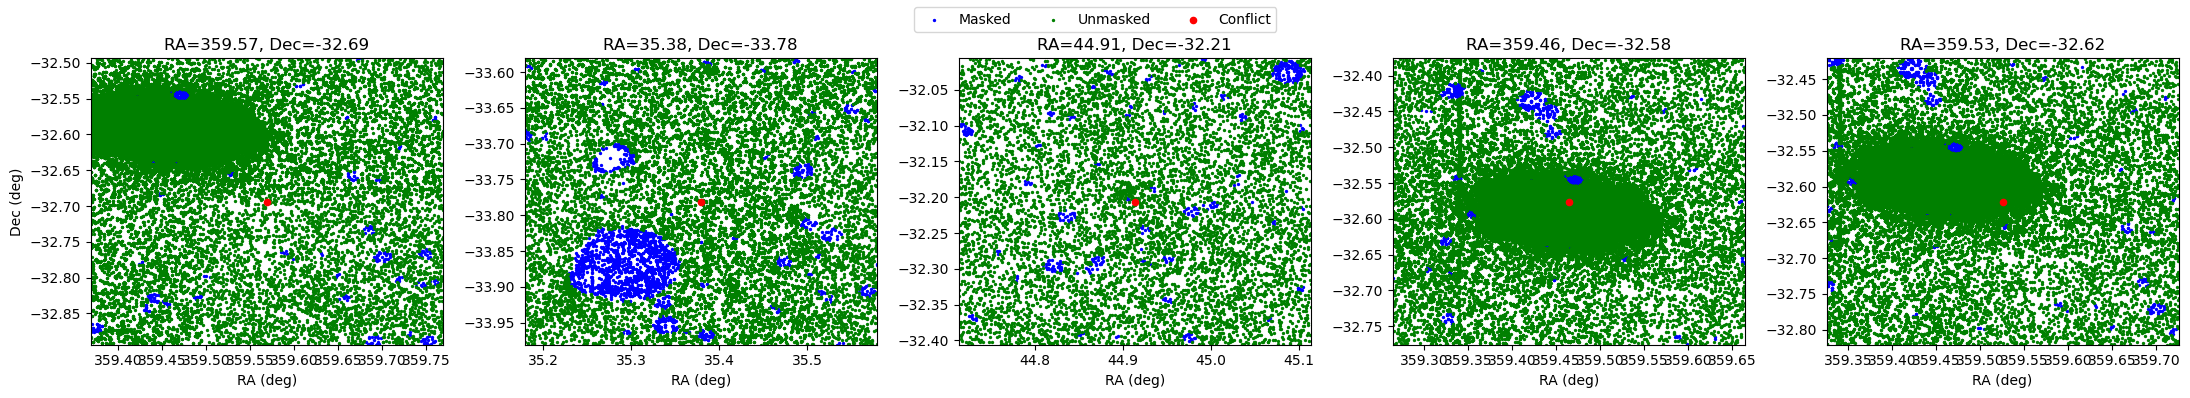

In [66]:

# Randomly select 5 conflict sources
sample = me_not_s.sample(5, random_state=42)

fig, axs = plt.subplots(1, 5, figsize=(22, 4))
window = 0.2

for i, (index, row) in enumerate(sample.iterrows()):
    ra_c, dec_c = row['RAmax'], row['Decmax']
    ax = axs[i]

    # Efficient query for just this small window — avoids loading everything into memory
    local = joined.query(
        "@ra_c - @window <= RAmax <= @ra_c + @window and "
        "@dec_c - @window <= Decmax <= @dec_c + @window"
    )

    # Split into masked/unmasked directly on the subset
    masked = local.loc[local['masked'], ['RAmax', 'Decmax']]
    unmasked = local.loc[local['not_masked'], ['RAmax', 'Decmax']]

    # Scatter small subsets only
    if not masked.empty:
        ax.scatter(masked['RAmax'], masked['Decmax'], color='blue', s=2, rasterized=True)
    if not unmasked.empty:
        ax.scatter(unmasked['RAmax'], unmasked['Decmax'], color='green', s=2, rasterized=True)

    # Conflict source in red
    ax.scatter([ra_c], [dec_c], color='red', s=20, zorder=5)

    # Axes and labels
    ax.set_xlim(ra_c - window, ra_c + window)
    ax.set_ylim(dec_c - window, dec_c + window)
    ax.set_aspect('auto')
    ax.set_title(f'RA={ra_c:.2f}, Dec={dec_c:.2f}')
    ax.set_xlabel('RA (deg)')
    if i == 0:
        ax.set_ylabel('Dec (deg)')

    # Explicitly delete locals to free memory
    del local, masked, unmasked

fig.legend(['Masked', 'Unmasked', 'Conflict'], loc='upper center', ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('mask_comparison_mine_not_sabines.png', dpi=300)
plt.show()


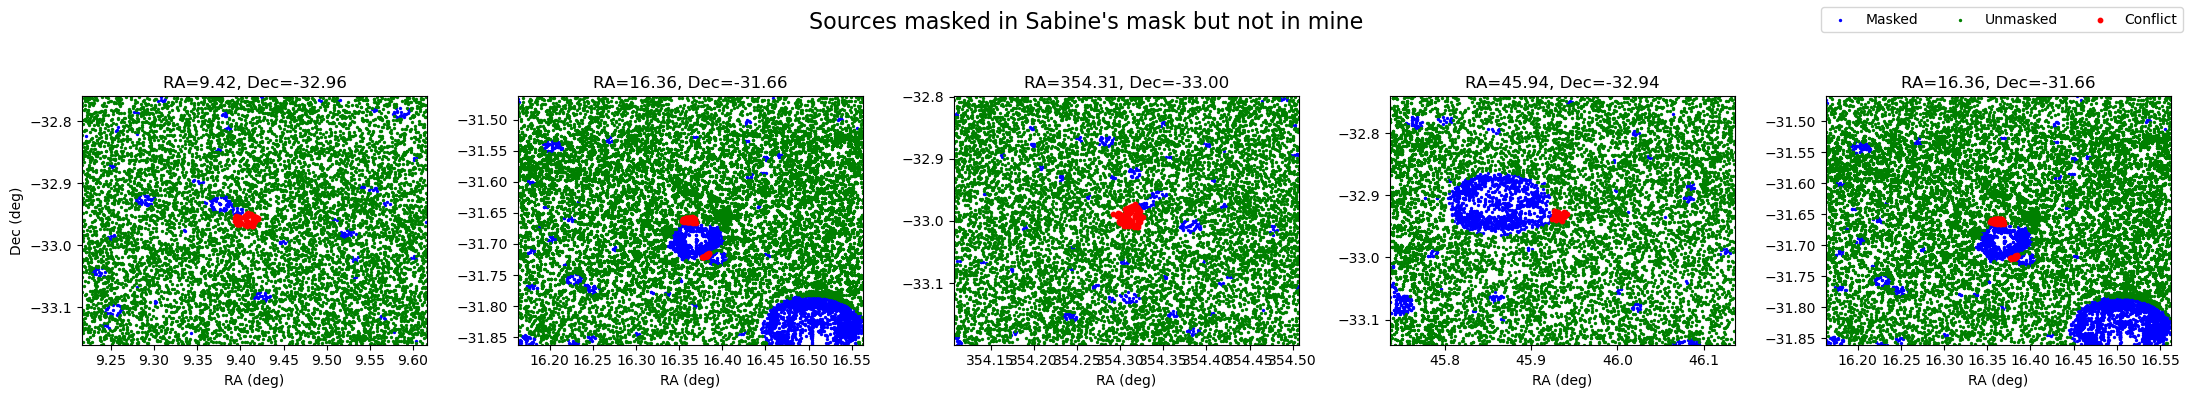

In [61]:
import matplotlib.pyplot as plt

# Randomly select 5 conflict sources to center panels on
sample = s_not_me.sample(5, random_state=10)

# Preload conflict coordinates once
conflict_ra = s_not_me['RAmax'].to_numpy()
conflict_dec = s_not_me['Decmax'].to_numpy()

fig, axs = plt.subplots(1, 5, figsize=(22, 4))
window = 0.2

for i, (index, row) in enumerate(sample.iterrows()):
    ra_c, dec_c = row['RAmax'], row['Decmax']
    ax = axs[i]

    # Query the joined catalog only within the small window
    local = joined.query(
        "@ra_c - @window <= RAmax <= @ra_c + @window and "
        "@dec_c - @window <= Decmax <= @dec_c + @window"
    )

    # Split into masked/unmasked subsets
    masked = local.loc[local['masked'], ['RAmax', 'Decmax']]
    unmasked = local.loc[local['not_masked'], ['RAmax', 'Decmax']]

    # Filter conflicts that fall inside this same window
    csel = (
        (conflict_ra >= ra_c - window) & (conflict_ra <= ra_c + window) &
        (conflict_dec >= dec_c - window) & (conflict_dec <= dec_c + window)
    )

    # Plot local subsets only
    if not masked.empty:
        ax.scatter(masked['RAmax'], masked['Decmax'], color='blue', s=2, rasterized=True)
    if not unmasked.empty:
        ax.scatter(unmasked['RAmax'], unmasked['Decmax'], color='green', s=2, rasterized=True)
    if csel.any():
        ax.scatter(conflict_ra[csel], conflict_dec[csel], color='red', s=10, zorder=5)

    # Axes and labels
    ax.set_xlim(ra_c - window, ra_c + window)
    ax.set_ylim(dec_c - window, dec_c + window)
    ax.set_aspect('auto')
    ax.set_title(f'RA={ra_c:.2f}, Dec={dec_c:.2f}')
    ax.set_xlabel('RA (deg)')
    if i == 0:
        ax.set_ylabel('Dec (deg)')

    del local, masked, unmasked

fig.legend(['Masked', 'Unmasked', 'Conflict'], ncol=3)
fig.suptitle('Sources masked in Sabine\'s mask but not in mine', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('mask_comparison_sabines_not_mine.png', dpi=300)
plt.show()


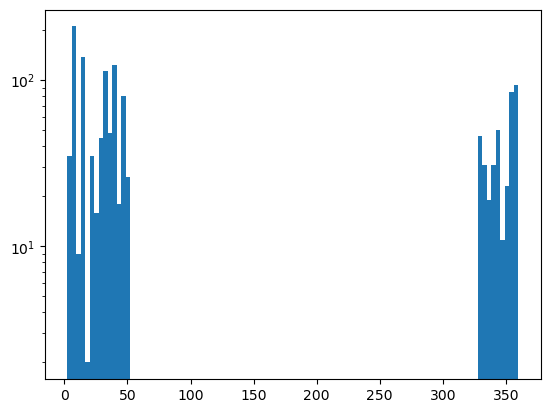

(array([ 17.,   5.,   0.,   0.,   0.,   0., 115.,  20.,   2.,   1.,   4.,
          6.,   0.,   0.,   0.,   7.,   0.,   0.,   4.,   0.,   4.,   0.,
          0.,   7.,   0.,   7.,   0.,   0.,  21., 129.,   6.,   0.,   4.,
          0.,   5.,   0.,   0.,   0.,   0.,   9.,  38.,   0.,   4.,   4.,
         26., 114.,   0.,  26.,   0.,  17.,   4.,   2.,   1.,   0.,   6.,
         12.,   0.,   0.,   0.,  23.,   0.,   0.,   9.,   2.,   0.,   0.,
         63.,   0., 102.,   1.,   2.,  10.,   7.,   0.,   9.,  52.,  62.,
          0.,  81.,   5.,   0.,  11.,   2.,   0.,   0.,  71.,  37.,   0.,
          0.,   0.,  30.,   0.,  17.,  41.,   0.,   2.,  16.,   2.,   6.,
          1.]),
 array([-35.40573551, -35.32289599, -35.24005647, -35.15721695,
        -35.07437742, -34.9915379 , -34.90869838, -34.82585886,
        -34.74301934, -34.66017981, -34.57734029, -34.49450077,
        -34.41166125, -34.32882173, -34.2459822 , -34.16314268,
        -34.08030316, -33.99746364, -33.91462412, -33.83178459

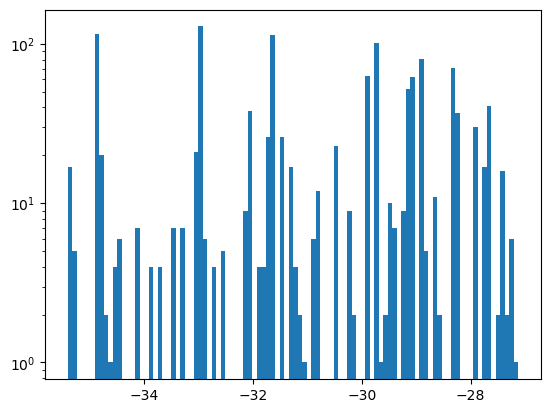

In [23]:
plt.hist(s_not_me['RAmax'], bins = 100, log=True)
plt.show()
plt.hist(s_not_me['Decmax'], bins = 100, log=True)

In [24]:
def read_mask_polygons(filenames):
    """
    Reads multiple .dat files containing RA/Dec polygon vertex pairs.
    Each line (or contiguous block) defines one polygon.

    Returns:
        polygons: list of Nx2 numpy arrays (RA, Dec)
    """
    import numpy as np
    polygons = []
    for fname in filenames:
        with open(fname, 'r') as f:
            for line in f:
                vals = line.strip().split()
                if len(vals) < 4:  # skip empty or invalid lines
                    continue
                coords = np.array(vals, dtype=float).reshape(-1, 2)
                polygons.append(coords)
    return polygons


In [71]:
polygons = read_mask_polygons(['/Users/sp624AA/Code/waves_polygon_mask/input_data/ngc_s.dat'])

In [72]:
polygons

[array([[358.59417278, -27.17435648],
        [358.58546994, -27.17433968],
        [358.58674154, -27.20758778],
        [358.5932083 , -27.2065612 ],
        [358.59417278, -27.17435648]]),
 array([[347.42747247, -28.17049427],
        [347.42249219, -28.1800575 ],
        [347.42470633, -28.19255449],
        [347.43491939, -28.20113343],
        [347.44343289, -28.20199111],
        [347.44877422, -28.18841267],
        [347.45187593, -28.17969171],
        [347.44594805, -28.17172705],
        [347.43414305, -28.1697127 ],
        [347.42747247, -28.17049427]]),
 array([[359.5123781, -32.5371596],
        [359.4792815, -32.5269073],
        [359.4375935, -32.5209456],
        [359.3952565, -32.527497 ],
        [359.3528659, -32.5407806],
        [359.3424058, -32.5643402],
        [359.3461516, -32.6000208],
        [359.359141 , -32.6237007],
        [359.3864547, -32.6460039],
        [359.430401 , -32.665486 ],
        [359.4916892, -32.6590013],
        [359.522072 , -32.6504

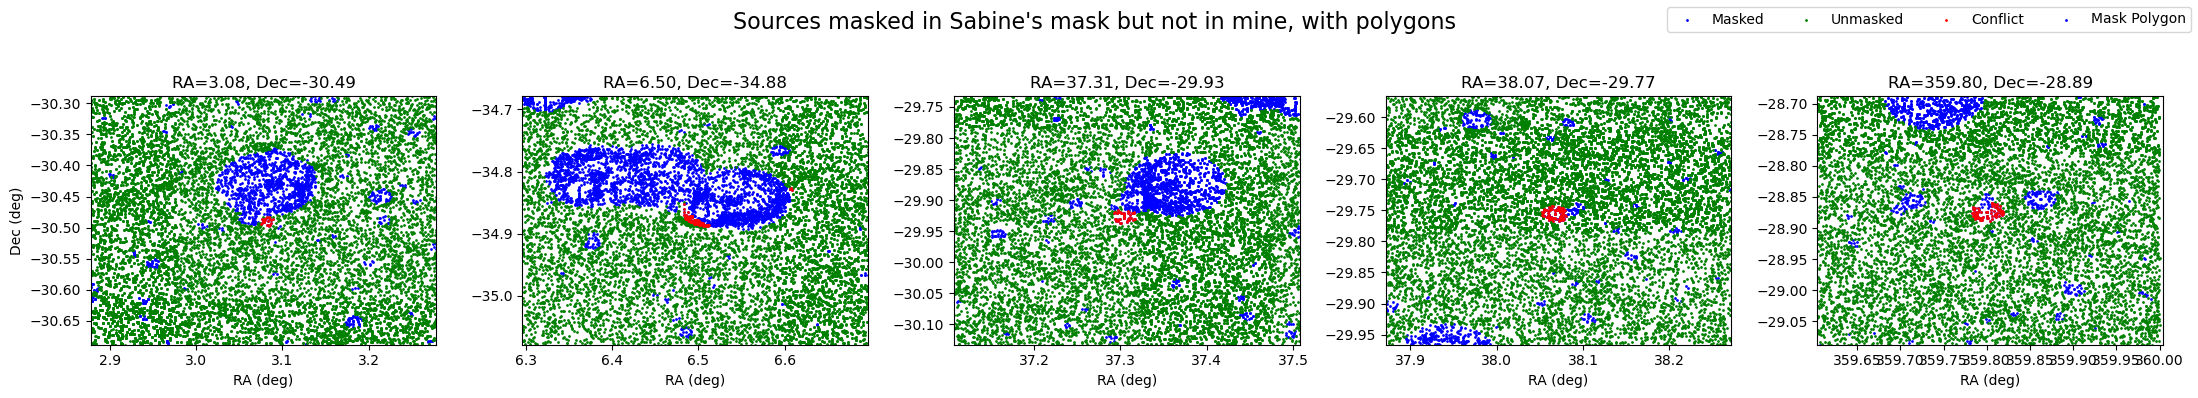

In [78]:
# --- Randomly select conflicts to center panels ---
sample = s_not_me.sample(5, random_state=42)

# --- Preload conflicts for overplotting ---
conflict_ra = s_not_me['RAmax'].to_numpy()
conflict_dec = s_not_me['Decmax'].to_numpy()

fig, axs = plt.subplots(1, 5, figsize=(22, 4))
window = 0.2

for i, (index, row) in enumerate(sample.iterrows()):
    ra_c, dec_c = row['RAmax'], row['Decmax']
    ax = axs[i]

    # Query joined catalog efficiently for the small window
    local = joined.query(
        "@ra_c - @window <= RAmax <= @ra_c + @window and "
        "@dec_c - @window <= Decmax <= @dec_c + @window"
    )

    masked = local.loc[local['masked'], ['RAmax', 'Decmax']]
    unmasked = local.loc[local['not_masked'], ['RAmax', 'Decmax']]

    # Conflicts that fall inside this window
    csel = (
        (conflict_ra >= ra_c - window) & (conflict_ra <= ra_c + window) &
        (conflict_dec >= dec_c - window) & (conflict_dec <= dec_c + window)
    )

    # Scatter subsets
    if not masked.empty:
        ax.scatter(masked['RAmax'], masked['Decmax'], color='blue', s=1, rasterized=True)
    if not unmasked.empty:
        ax.scatter(unmasked['RAmax'], unmasked['Decmax'], color='green', s=1, rasterized=True)
    if csel.any():
        ax.scatter(conflict_ra[csel], conflict_dec[csel], color='red', s=1, zorder=5)

    # Plot polygons that intersect the window
    for poly in polygons:
        ra_min, ra_max = poly[:, 0].min(), poly[:, 0].max()
        dec_min, dec_max = poly[:, 1].min(), poly[:, 1].max()
        if (ra_max >= ra_c - window) and (ra_min <= ra_c + window) and \
           (dec_max >= dec_c - window) and (dec_min <= dec_c + window):
            ax.plot(poly[:, 0], poly[:, 1], color='orange', lw=1.0, alpha=0.8, zorder=4)

    # Axes and labels
    ax.set_xlim(ra_c - window, ra_c + window)
    ax.set_ylim(dec_c - window, dec_c + window)
    ax.set_aspect('auto')
    ax.set_title(f'RA={ra_c:.2f}, Dec={dec_c:.2f}')
    ax.set_xlabel('RA (deg)')
    if i == 0:
        ax.set_ylabel('Dec (deg)')

    del local, masked, unmasked

fig.legend(['Masked', 'Unmasked', 'Conflict', 'Mask Polygon'],
            ncol=4)
fig.suptitle('Sources masked in Sabine\'s mask but not in mine, with polygons', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('mask_comparison_with_polygons.png', dpi=300)
plt.show()

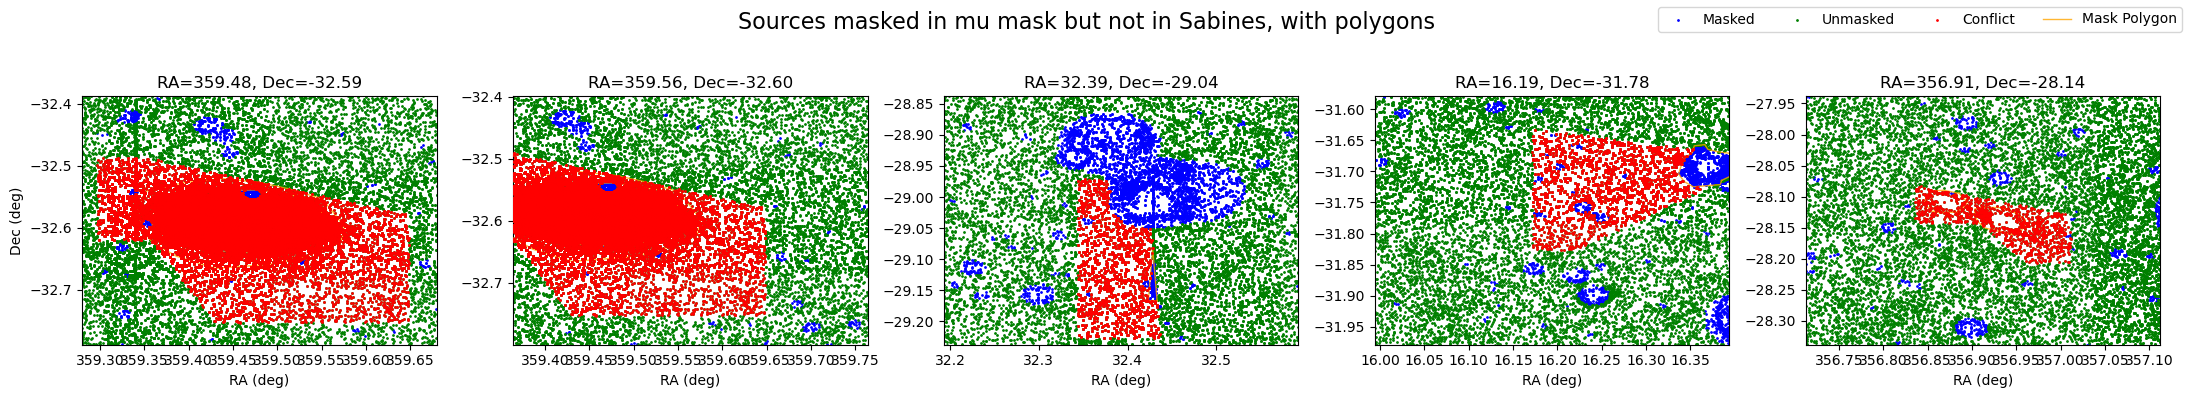

In [76]:
# --- Randomly select conflicts to center panels ---
sample = me_not_s.sample(5, random_state=10)

# --- Preload conflicts for overplotting ---
conflict_ra = me_not_s['RAmax'].to_numpy()
conflict_dec = me_not_s['Decmax'].to_numpy()

fig, axs = plt.subplots(1, 5, figsize=(22, 4))
window = 0.2

for i, (index, row) in enumerate(sample.iterrows()):
    ra_c, dec_c = row['RAmax'], row['Decmax']
    ax = axs[i]

    # Query joined catalog efficiently for the small window
    local = joined.query(
        "@ra_c - @window <= RAmax <= @ra_c + @window and "
        "@dec_c - @window <= Decmax <= @dec_c + @window"
    )

    masked = local.loc[local['masked'], ['RAmax', 'Decmax']]
    unmasked = local.loc[local['not_masked'], ['RAmax', 'Decmax']]

    # Conflicts that fall inside this window
    csel = (
        (conflict_ra >= ra_c - window) & (conflict_ra <= ra_c + window) &
        (conflict_dec >= dec_c - window) & (conflict_dec <= dec_c + window)
    )

    # Scatter subsets
    if not masked.empty:
        ax.scatter(masked['RAmax'], masked['Decmax'], color='blue', s=1, rasterized=True)
    if not unmasked.empty:
        ax.scatter(unmasked['RAmax'], unmasked['Decmax'], color='green', s=1, rasterized=True)
    if csel.any():
        ax.scatter(conflict_ra[csel], conflict_dec[csel], color='red', s=1, zorder=5)

    # Plot polygons that intersect the window
    for poly in polygons:
        ra_min, ra_max = poly[:, 0].min(), poly[:, 0].max()
        dec_min, dec_max = poly[:, 1].min(), poly[:, 1].max()
        if (ra_max >= ra_c - window) and (ra_min <= ra_c + window) and \
           (dec_max >= dec_c - window) and (dec_min <= dec_c + window):
            ax.plot(poly[:, 0], poly[:, 1], color='orange', lw=1.0, alpha=0.8, zorder=4)

    # Axes and labels
    ax.set_xlim(ra_c - window, ra_c + window)
    ax.set_ylim(dec_c - window, dec_c + window)
    ax.set_aspect('auto')
    ax.set_title(f'RA={ra_c:.2f}, Dec={dec_c:.2f}')
    ax.set_xlabel('RA (deg)')
    if i == 0:
        ax.set_ylabel('Dec (deg)')

    del local, masked, unmasked

fig.legend(['Masked', 'Unmasked', 'Conflict', 'Mask Polygon'],
            ncol=4)
fig.suptitle('Sources masked in mu mask but not in Sabines, with polygons', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('mask_comparison_s_with_polygons_me_not_s.png', dpi=300)
plt.show()

In [28]:
import numpy as np
from math import radians, sin, cos, atan2, sqrt

import numpy as np
from math import radians, degrees, sin, cos, atan2, pi, isfinite

import numpy as np
from math import radians, cos, pi, isfinite

def spherical_polygon_area(verts):
    """
    Compute approximate spherical area in deg² using a robust small-angle formula.
    Returns positive area for MANGLE's right-handed convention.

    Works accurately for polygons up to a few degrees across.
    """
    if len(verts) < 3:
        return 0.0

    ra = np.radians(verts[:, 0])
    dec = np.radians(verts[:, 1])

    # Use the spherical shoelace formula (Bretschneider's method on a sphere)
    # Reference: Chamberlain & Duquette (2007), JPL Publication 07-03
    # https://trs.jpl.nasa.gov/handle/2014/41271
    total = 0.0
    n = len(ra)
    for i in range(n):
        ra1, dec1 = ra[i - 1], dec[i - 1]
        ra2, dec2 = ra[i], dec[i]
        dRA = ra2 - ra1
        # Wrap ΔRA into [-π, π]
        if dRA < -pi:
            dRA += 2 * pi
        elif dRA > pi:
            dRA -= 2 * pi
        total += dRA * (sin(dec2) + sin(dec1))

    area_sr = abs(total) / 2.0
    # Convert steradians → deg²
    area_deg2 = area_sr * (180.0 / pi) ** 2

    if not isfinite(area_deg2):
        area_deg2 = 0.0
    return area_deg2




def polygon_stats(verts):
    """Return vertex count, ΔRA, ΔDec, and area in deg²."""
    ra = np.array([v[0] for v in verts])
    dec = np.array([v[1] for v in verts])
    area = spherical_polygon_area(verts)
    return len(verts), np.ptp(ra), np.ptp(dec), area


def check_polygons(all_polygons, 
                   max_vertices=300, 
                   max_dra=180, 
                   max_ddec=90, 
                   min_area_deg2=1e-6):
    """
    Prints polygons that may cause issues for MANGLE:
    - Too many vertices
    - Too large RA/Dec span
    - Extremely small area (deg²)
    """
    for i, v in enumerate(all_polygons):
        n, dra, ddec, area = polygon_stats(v)
        print(f"Polygon {i:3d}: N={n:4d}, ΔRA={dra:8.3f}, ΔDec={ddec:7.3f}, Area={area:10.6e} deg²")
        if (n > max_vertices) or (dra > max_dra) or (ddec > max_ddec) or (area < min_area_deg2):
            print(f"⚠️ Polygon {i:3d}: N={n:4d}, ΔRA={dra:8.3f}, ΔDec={ddec:7.3f}, Area={area:10.6e} deg²")


In [73]:
import numpy as np

def read_mask_polygons(filenames):
    """
    Reads one or more .dat files containing RA/Dec polygon vertex pairs.
    Each polygon may span multiple lines, separated by blank lines.

    Ignores 'r' or 'l' markers used to indicate handedness for MANGLE.

    Returns:
        polygons : list of Nx2 numpy arrays (RA, Dec)
    """
    polygons = []
    for fname in filenames:
        with open(fname, 'r') as f:
            block = []
            for line in f:
                vals = line.strip().split()

                # Skip empty lines → end of polygon
                if not vals:
                    if block:
                        polygons.append(np.array(block, dtype=float))
                        block = []
                    continue

                # Filter out 'r' or 'l' orientation markers
                clean_vals = [v for v in vals if v.lower() not in ['r', 'l']]

                # Convert remaining to floats
                try:
                    floats = [float(v) for v in clean_vals]
                except ValueError as e:
                    raise ValueError(f"Bad line in {fname}: {line.strip()}") from e

                if len(floats) % 2 != 0:
                    raise ValueError(f"Odd number of coordinates in line of {fname}: {line.strip()}")

                # Reshape into (N,2) RA/Dec pairs
                pairs = np.array(floats).reshape(-1, 2)
                block.extend(pairs.tolist())

            # Handle last polygon if file doesn’t end with blank line
            if block:
                polygons.append(np.array(block, dtype=float))
    return polygons


In [74]:
polygons = read_mask_polygons([
    "/Users/sp624AA/Code/waves_polygon_mask/input_data/ngc_n.dat",
    "/Users/sp624AA/Code/waves_polygon_mask/input_data/ngc_s.dat"
])

# 2️⃣ Run QA checks
check_polygons(polygons)

Polygon   0: N=  12, ΔRA=   0.034, ΔDec=  0.028, Area=7.307801e-04 deg²
Polygon   1: N=  11, ΔRA=   0.026, ΔDec=  0.055, Area=4.844733e-04 deg²
Polygon   2: N=   7, ΔRA=   0.021, ΔDec=  0.021, Area=3.122640e-04 deg²
Polygon   3: N=  12, ΔRA=   0.026, ΔDec=  0.051, Area=9.182442e-04 deg²
Polygon   4: N=  18, ΔRA=   0.128, ΔDec=  0.082, Area=8.427832e-03 deg²
Polygon   5: N=  13, ΔRA=   0.036, ΔDec=  0.041, Area=1.096826e-03 deg²
Polygon   6: N=   5, ΔRA=   0.010, ΔDec=  0.043, Area=3.447732e-04 deg²
Polygon   7: N=  16, ΔRA=   0.048, ΔDec=  0.034, Area=9.730466e-04 deg²
Polygon   8: N=  15, ΔRA=   0.030, ΔDec=  0.048, Area=1.094447e-03 deg²
Polygon   9: N=  14, ΔRA=   0.078, ΔDec=  0.054, Area=3.265268e-03 deg²
Polygon  10: N=  10, ΔRA=   0.021, ΔDec=  0.029, Area=4.510051e-04 deg²
Polygon  11: N=  13, ΔRA=   0.043, ΔDec=  0.040, Area=1.252336e-03 deg²
Polygon  12: N=  14, ΔRA=   0.072, ΔDec=  0.071, Area=3.983844e-03 deg²
Polygon  13: N=  17, ΔRA=   0.074, ΔDec=  0.059, Area=3.120081e-